In [93]:
from itertools import chain
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytesseract


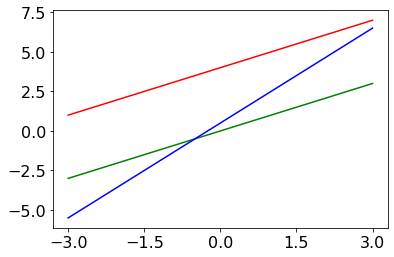

In [61]:
from pytesseract import Output
plt.rcParams.update({'font.size': 16,
                     'savefig.dpi': 300})
# Create an image plot

x = np.linspace(-3,3,100)
plt.plot(x,x, 'g')
plt.plot(x, 2 * x + 0.5, 'b')
plt.plot(x, x + 4, 'r')

plt.xticks(np.arange(-3,3.5,1.5))
plt.yticks(np.arange(-5,7.6,2.5))
plt.savefig("plots/three_linear_neg_graphs.png")

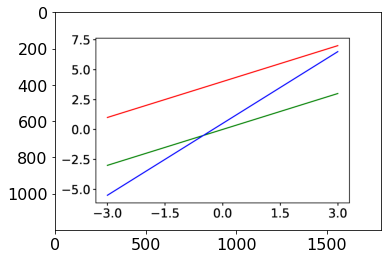

In [62]:
use_image = "plots/three_linear_neg_graphs.png"

# Load image into numpy array and display it
base_img = cv2.imread(use_image)

def show_image(img, axis=None):
    # Helper function to disply the image in the correct colors
    rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    if axis is None:
        plt.figure()
        plt.imshow(rgb)
    else:
        axis.imshow(rgb)

show_image(base_img)

In [63]:
class Rect:
    def __init__(self, x, y, w, h):
        self.x = x
        self.y = y
        self.w = w
        self.h = h

    @property
    def area(self):
        return self.w * self.h

    def intersect(self, other):
        no_x = self.x + self.w < other.x or self.x > other.x + other.w
        no_y = self.y + self.h < other.y or self.y > other.y + other.h
        return not no_x and not no_y

    def __str__(self):
        return f"({self.x}, {self.y}, {self.w}, {self.h})"

    def __repr__(self):
        return str(self)

In [64]:
def filter_by_area(rects, std_factor=2):
    # filter contours that are too far from the most n_boxes
    areas = np.array([r.area for r in rects])

    median = np.mean(areas)
    std = np.std(areas)

    # only keep rectangles with an area of less than std_factor std
    rects = filter(lambda r: abs(r.area - median) <= std_factor * std, rects)
    return  list(rects)

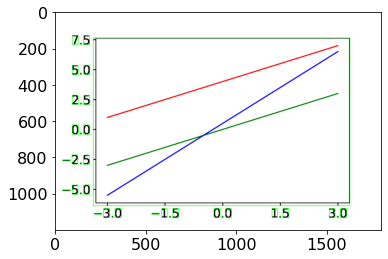

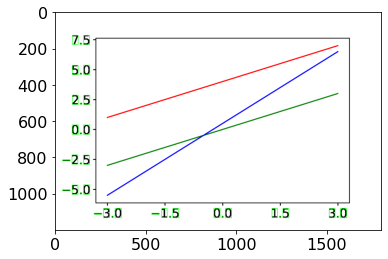

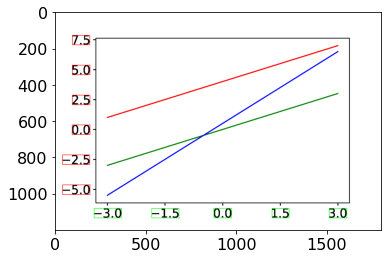

In [102]:
img_gray = cv2.cvtColor(base_img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY_INV)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

rectangles = [Rect(*cv2.boundingRect(c)) for c in contours]

# Show all contours found
img2 = base_img.copy()
for c in rectangles:
    img2 = cv2.rectangle(img2, (c.x,c.y), (c.x+c.w, c.y+c.h),(0, 255, 0), 2)
show_image(img2)

# filter gigantic contours, e.g. here the box around the plots
filtered = filter_by_area(rectangles)
img3 = base_img.copy()
for c in filtered:
    img3 = cv2.rectangle(img3, (c.x,c.y), (c.x+c.w, c.y+c.h),(0, 255, 0), 2)
show_image(img3)

def group_rects_per_axis(rects):
    """
    Gets a list of Rect objects and separates the rectangle into x and y axis.
    This is done by leveraging the fact that x-labels (approx.) all have the same floor point
    :param rects: iterable of Rect objects
    :return: tuple of numpy arrays (x rects,y rects)
    """
    # Get the font size in px to include the "-" of negative values
    font_height = max(r.h for r in rects)
    max_dev = font_height / 2.

    bottom_alignment = np.array([x.y + x.h for x in rects])
    x_boxes_mask = np.abs(bottom_alignment - max(bottom_alignment)) <= max_dev
    x_boxes_indices = np.nonzero(x_boxes_mask)
    y_boxes_indices = np.nonzero(~x_boxes_mask)

    rects = np.array(rects)
    return rects[x_boxes_indices], rects[y_boxes_indices]

def merge_rects(x_arr, y_arr):
    """
    Merge all rectangles which belong together ([1][.][5] -> [1.5]) for x and y axis respectively.
    :param x_arr: iterable of Rect objects
    :param y_arr: iterable of Rect objects
    :return: tuple of list[Rect] objects: outer-x-label-rects, outer-y-label-rects
    """
    def get_min_rects(groups):
        all_rects = []
        for g in groups:
            rects = []
            for r in g:
                rects.append((r.x,r.y))
                rects.append((r.x+r.w,r.y+r.h))
            all_rects.append(Rect(*cv2.boundingRect(np.asarray(rects))))
        return all_rects

    def merge_x(arr):
        font_width = max(r.w for r in x_arr)
        max_width_dev = font_width / 2.
        all_groups = []
        curr_group = []
        for r in sorted(arr, key=lambda r: r.x):
            if not curr_group:
                curr_group.append(r)
            else:
                last_elem = curr_group[-1]
                if abs(r.x - (last_elem.x + last_elem.w)) <= max_width_dev:
                    curr_group.append(r)
                else:
                    all_groups.append(curr_group)
                    curr_group = [r]
        all_groups.append(curr_group)
        return get_min_rects(all_groups)

    def merge_y(arr):
        max_y_dist = max(x.h for x in arr) / 2.
        all_groups = []
        curr_group = []
        for r in sorted(arr, key=lambda r: (r.y + r.h, r.x)):
            if not curr_group:
                curr_group.append(r)
            else:
                last_elem = curr_group[-1]
                if abs(r.y + r.h - (last_elem.y + last_elem.h)) <= max_y_dist:
                    curr_group.append(r)
                else:
                    all_groups.append(curr_group)
                    curr_group = [r]
        all_groups.append(curr_group)
        return get_min_rects(all_groups)

    x = merge_x(x_arr)
    y = merge_y(y_arr)
    return x, y

xs, ys = group_rects_per_axis(filtered)
xs, ys = merge_rects(xs, ys)

# Display x and y boxes in separate colors
img4 = base_img.copy()
for c in xs:
    img4 = cv2.rectangle(img4, (c.x,c.y), (c.x+c.w, c.y+c.h),(0, 255, 0), 2)
for c in ys:
    img4 = cv2.rectangle(img4, (c.x,c.y), (c.x+c.w, c.y+c.h),(0, 0, 255), 2)
show_image(img4)

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 20, 20, 20, 20], 'top': [0, 20, 20, 20, 20], 'width': [192, 150, 150, 150, 150], 'height': [94, 52, 52, 52, 52], 'conf': ['-1', '-1', '-1', '-1', 0], 'text': ['', '', '', '', '-3.0']}
{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 20, 20, 20, 20], 'top': [0, 20, 20, 20, 20], 'width': [191, 149, 149, 149, 149], 'height': [93, 51, 51, 51, 51], 'conf': ['-1', '-1', '-1', '-1', 48], 'text': ['', '', '', '', '-1.5']}
{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 20, 20, 20, 20], 'top': [0, 20, 20, 20, 20], 'width': [139, 97, 97, 97, 97], 'h

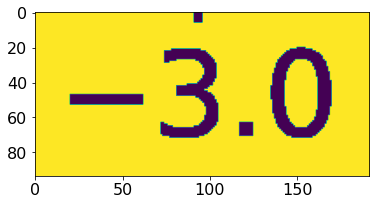

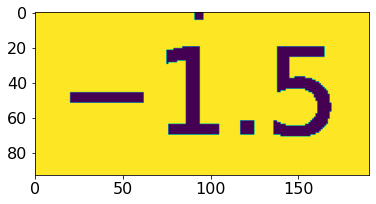

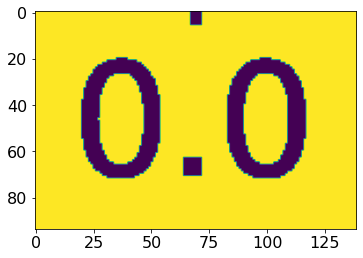

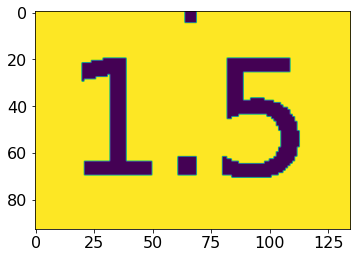

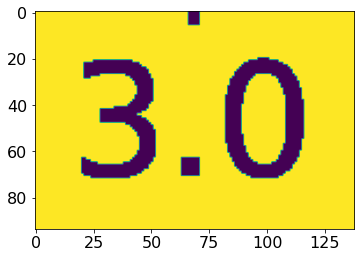

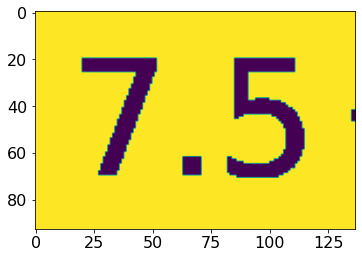

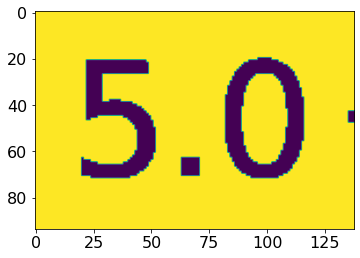

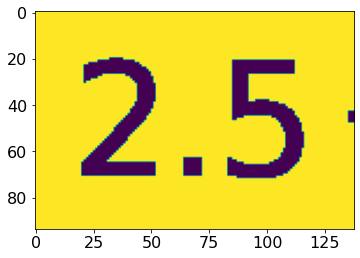

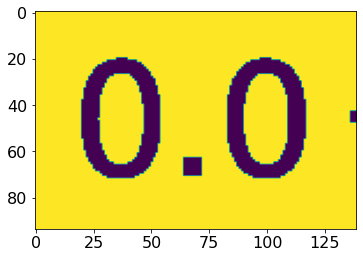

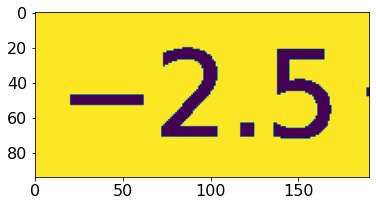

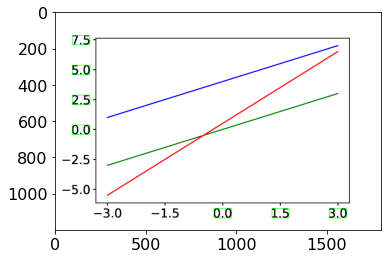

In [109]:
def add_border_to_box(r, img_shape, border_size=20):
    x = max(0, r.x - border_size)
    y = max(0, r.y - border_size)
    w = min(r.w + 2 * border_size, img_shape[0])
    h = min(r.h + 2 * border_size, img_shape[1])
    return Rect(x,y,w,h)

def boxes_to_label_value(box_list, bin_image):
    letter_boxes = []
    for rect in box_list:
        # extra borders to make the contours inside of the rectangle
        padded_rect = add_border_to_box(rect, base_img.shape)
        roi = bin_image[padded_rect.y:padded_rect.y + padded_rect.h + 1, padded_rect.x:padded_rect.x + padded_rect.w + 1]
        plt.figure()
        plt.imshow(roi)
        # try using an empty image, put in the roi and then apply tesseract. sending once might be cheaper
        ocr_data = pytesseract.image_to_data(roi, output_type=Output.DICT, config=f'--psm 11 -c tessedit_char_whitelist=0123456789.-')
        print(ocr_data)
        n_boxes = len(ocr_data['text'])
        for i in range(n_boxes):
            if int(ocr_data['conf'][i]) > 60:
                letter_boxes.append((float(ocr_data["text"][i]), rect))
    return letter_boxes


binary_image = cv2.cvtColor(base_img.copy(), cv2.COLOR_BGR2GRAY)
binary_image = cv2.threshold(binary_image, 0, 255, cv2.THRESH_OTSU)[1]
x_labels = boxes_to_label_value(xs, binary_image)
y_labels = boxes_to_label_value(ys, binary_image)

ocr_img = base_img.copy()
for c, box in chain(x_labels, y_labels):
    ocr_img = cv2.rectangle(ocr_img, (box.x, box.y), (box.x + box.w, box.y + box.h), (0,255,0), 2)
    print(c)
plt.imshow(ocr_img)


In [110]:
class PixelToLabelLookup:
    def __init__(self, x_values, y_values):
        """
        Class to convert found pixels (data values) to the corresponding value as indicated by the axis labels
        :param all_label_boxes:
        """
        self.x, self.y = x_values, y_values
        print(f"X-Labels: {self.x}")
        print(f"Y-Labels: {self.y}")
        self.x_func, self.y_func = self._create_lookup_fns()

    def linear_regression(self, mean_points):
        points = np.array(mean_points).T
        assert len(points.shape) == 2

        x, y = points[0], points[1]

        s_xy = np.sum((x - x.mean()) * (y - y.mean()))
        s_xx = np.sum((x - x.mean()) ** 2)

        b = float(s_xy) / s_xx
        intercept = y.mean() - b * x.mean()

        def reg_fn(px):
            return np.round(intercept + b * px, 2)

        return reg_fn

    def _create_lookup_fns(self):
        mean_points_x = [(r.x + r.w / 2, val) for val, r in self.x]
        mean_points_y = [(r.y + r.h / 2, val) for val, r in self.y]
        print(mean_points_x)
        print(mean_points_y)
        return self.linear_regression(mean_points_x), self.linear_regression(mean_points_y)

    def lookup(self, px):
        return self.x_func(px[0]), self.y_func(px[1])

    def __call__(self, arr: np.ndarray):
        # lookup for a numpy array along the last dimension.
        values = np.apply_along_axis(self.lookup, -1, arr)
        return values

label_lookup = PixelToLabelLookup(x_labels, y_labels)

X-Labels: [(0.0, (874, 1080, 98, 53)), (1.5, (1194, 1081, 94, 52)), (3.0, (1509, 1080, 97, 53))]
Y-Labels: [(7.5, (95, 128, 96, 52)), (5.0, (95, 292, 97, 53)), (2.5, (95, 457, 97, 53)), (0.0, (94, 621, 98, 53))]
[(923.0, 0.0), (1241.0, 1.5), (1557.5, 3.0)]
[(154.0, 7.5), (318.5, 5.0), (483.5, 2.5), (647.5, 0.0)]


found 3 colors/graphs


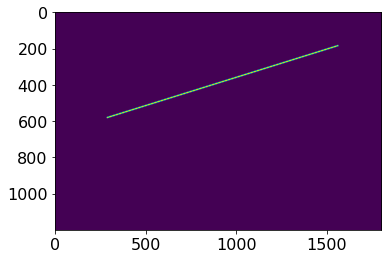

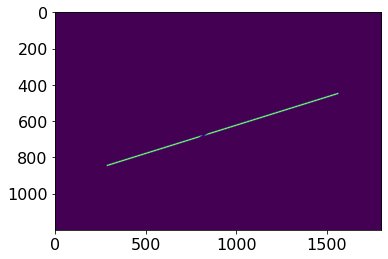

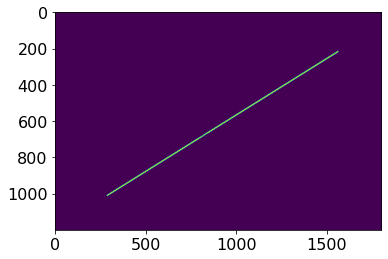

In [111]:
# If we have multiple graphs in a plot, we separate them by color.
# Change into the HSV color space because it better represents the perceived color.
# as we do not have many different colors we can easily threshold them to separate values, using the first (hue) value only
# problems: this does not work for black graphs

def separate_by_color(img_):
    hsv_img = cv2.cvtColor(img_, cv2.COLOR_BGR2HSV)

    hue_values = np.transpose(hsv_img, (2,0,1))[0].flatten()

    # Get the most frequent hue values, i.e. present colors without noise
    unq, counts = np.unique(hue_values, return_counts=True)
    unique_threshold = 20
    colors = unq[counts > unique_threshold]

    color_masks = {}
    for c in colors:
        # define a range to make red possible as it is [0,255,255]
        lower = np.array([c,50,50])
        upper = np.array([c,255,255])

        mask = cv2.inRange(hsv_img, lower, upper)
        color_masks[c] = mask
        plt.subplots()
        plt.imshow(mask)
    return color_masks

color_masks = separate_by_color(base_img)
print(f"found {len(color_masks)} colors/graphs")

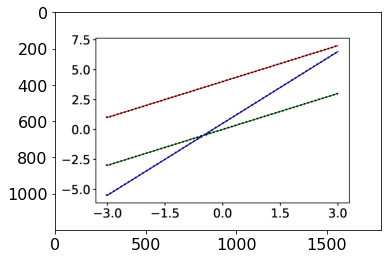

In [112]:
from collections import defaultdict

def get_pixels_for_one_graph(graph_mask, x_resolution=10):
    """

    :param graph_mask: np.ndarray of shape (height, width)
    :param x_resolution: the space between 2 adjacent points
    :return:
    """
    # find non-zero indices
    data = np.argwhere(graph_mask.T > 0)
    data_points_agg = defaultdict(list)
    np.apply_along_axis(lambda row: data_points_agg[row[0]].append(row[1]), -1, data)

    # use the median value for each x value ( as the stroke of a lineplot might be thicker)
    points = np.array([[x, np.median(y)] for x,y in data_points_agg.items()], dtype=np.int)

    # down_scale the points to the given resolution
    down_scale = points[np.arange(0, len(points), x_resolution)]

    return down_scale

# show the data_points in the plot
cat_img = base_img.copy()
pixel_data = {}
real_data = {}
for c, m in color_masks.items():
    dp = get_pixels_for_one_graph(m, 20)
    real_values = label_lookup(dp)
    pixel_data[c] = dp
    real_data[c] = real_values
    for d in dp:
        cv2.circle(cat_img, tuple(d), radius=5, color=(0,0,0), thickness=cv2.FILLED)
show_image(cat_img)

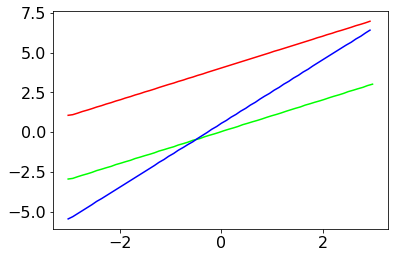

In [113]:
# Pixel data to actual label values
plt.figure()
for c, d in real_data.items():
    color_hue = np.array([[[c, 255,255]]], dtype=np.uint8)
    color_rgb = cv2.cvtColor(color_hue, cv2.COLOR_HSV2RGB).flatten()
    x,y = d.T
    plt.plot(x,y, color=tuple(color_rgb / 255.))

res = "plots/result.png"
plt.savefig(res)

Base-img vs recreated image


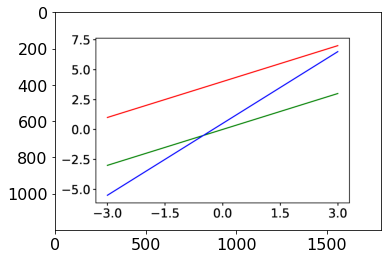

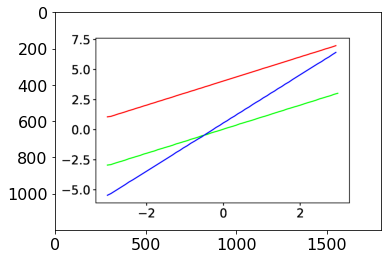

In [114]:
print("Base-img vs recreated image")
show_image(base_img)
show_image(cv2.imread(res))
